In [1]:
# others
# colab drive mount 
import os
from google.colab import drive
from google.colab import files
 
import pandas as pd
import numpy as np
import argparse
import datetime
from copy import deepcopy # Add Deepcopy for args
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
 
 
print(torch.__version__)

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

drive.mount('/content/drive')

# import os, pickle, joblib, argparse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1.8.1+cu101
Populating the interactive namespace from numpy and matplotlib
Mounted at /content/drive


In [2]:
# read file
raw_x_df = pd.read_csv('/content/drive/My Drive/bitcoin_dataset/train_x_df.csv')
raw_y_df = pd.read_csv('/content/drive/My Drive/bitcoin_dataset/train_y_df.csv')

print('Read files Complete!')

Read files Complete!


In [3]:
# ================================================= #
def df2d_to_array3d(df_2d):
    
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    print('DataFrame to array, Complete!')
    
    return array_3d
# ================================================= #

def train_test_spliter(arr):
    n = len(arr)
    num_features = arr.shape[2]
    
    train_arr = arr[0:int(n*0.9), :, :]
    val_arr = arr[int(n*0.9):, :, :]
    
    train_len = len(train_arr) 
    val_len = len(val_arr)
    
    print(
    f'''
    ======================================================
    Origin length is {n}, then total split length is {train_len, val_len}
    ======================================================
    train length is {train_arr.shape},
    val length is {val_arr.shape},
    num_features is ({num_features})
    '''
    )
    return train_arr, val_arr
# ================================================= #

def kbin_discretizer(input_array):

    kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal')
    processed_data = np.zeros((input_array.shape[0], input_array.shape[1], 1))
    
    for i in range(input_array.shape[0]):
        # coin_index_export args : (input_array, coin_num)
        globals()['processing_array{}'.format(i)] = input_array[i,:,1]
        
        #globals()['outliery_array{}'.format(i)] = train_y_array[outlier[i],:,1]
        kb.fit(globals()['processing_array{}'.format(i)].reshape(input_array.shape[1],1))
        globals()['processed_fit{}'.format(i)] = kb.transform(globals()['processing_array{}'.format(i)].reshape(input_array.shape[1],1))
        
        #globals()['outliery_fit{}'.format(i)] = kb.transform(globals()['outliery_array{}'.format(i)].reshape(120,1))
        processed_data[i,:,:] = globals()['processed_fit{}'.format(i)]
        
    return processed_data


def outlier_detecter(raw_y_arr, outlier_criteria = 0.05):

    open_arr = raw_y_arr[:, :, 1] #open col is 1

    outlier_list = []
    openrange_list = []

    for idx, temp_arr in enumerate(open_arr):
    
        temp_min = temp_arr.min()
        temp_max = temp_arr.max()
        temp_arr_range = temp_max - temp_min
        openrange_list.append(temp_arr_range)

        if temp_arr_range > outlier_criteria:
            outlier_list.append(idx)
            print(f'{idx}번째 open series is outlier sample!')
            print(f'temp array range is {temp_arr_range:.3}\n')
            

    return outlier_list, np.array(openrange_list)


In [4]:
# df to array 
raw_x_arr = df2d_to_array3d(raw_x_df)
raw_y_arr = df2d_to_array3d(raw_y_df)


DataFrame to array, Complete!
DataFrame to array, Complete!


In [27]:
outlier_list, openrange_list = outlier_detecter(raw_y_arr, 0.03)

2번째 open series is outlier sample!
temp array range is 0.0307

4번째 open series is outlier sample!
temp array range is 0.0519

6번째 open series is outlier sample!
temp array range is 0.0524

9번째 open series is outlier sample!
temp array range is 0.0331

20번째 open series is outlier sample!
temp array range is 0.0308

32번째 open series is outlier sample!
temp array range is 0.0582

45번째 open series is outlier sample!
temp array range is 0.0351

49번째 open series is outlier sample!
temp array range is 0.0343

54번째 open series is outlier sample!
temp array range is 0.0359

58번째 open series is outlier sample!
temp array range is 0.0868

71번째 open series is outlier sample!
temp array range is 0.0538

73번째 open series is outlier sample!
temp array range is 0.0302

75번째 open series is outlier sample!
temp array range is 0.0443

79번째 open series is outlier sample!
temp array range is 0.105

83번째 open series is outlier sample!
temp array range is 0.136

96번째 open series is outlier sample!
temp array

In [28]:
filtered_x_arr = np.delete(raw_x_arr, outlier_list, axis=0)
filtered_y_arr = np.delete(raw_y_arr, outlier_list, axis=0)


In [29]:
# dis_x_arr = kbin_discretizer(raw_x_arr)
# dis_y_arr = kbin_discretizer(raw_y_arr)

# raw_x_arr[:, :, 1] = dis_x_arr.squeeze()
# raw_y_arr[:, :, 1] = dis_y_arr.squeeze()

In [30]:
# train test slit
train_x_arr, val_x_arr = train_test_spliter(filtered_x_arr)
train_y_arr, val_y_arr = train_test_spliter(filtered_y_arr)



    Origin length is 6292, then total split length is (5662, 630)
    train length is (5662, 1380, 10),
    val length is (630, 1380, 10),
    num_features is (10)
    

    Origin length is 6292, then total split length is (5662, 630)
    train length is (5662, 120, 10),
    val length is (630, 120, 10),
    num_features is (10)
    


In [31]:
# ================================================= #
def coin_index_export(input_array, coin_num):
    ''' 함수 설명 : 코인별 인덱스 뽑기 '''
    
    index = []
    sample_id_len = input_array.shape[0]
    coin_num_col = 0 

    for sample_id in range(sample_id_len):
        if input_array[sample_id, 0, coin_num_col] == coin_num:
            # print(sample_id)
            index.append(sample_id)
    return index

# ================================================= #

def each_coin_normalization(train_x_arr):
    ''' 함수 설명 : 코인별 데이터 정규화 '''
    
    # 유니크 코인 번호
    unique_coin_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    #create empty scaled list
    scaled_train_x_arr = np.zeros((train_x_arr.shape[0], train_x_arr.shape[1], train_x_arr.shape[2]))
    
    for temp_coin_num in unique_coin_index:
        # 유니크 코인 번호 중 한 코인 번호씩 해당 코인에 맞는 인덱스 추출
        # ex) if temp_coin_num is 0, temp_coin_index = [3, 7, 8, 14...]
        temp_coin_index = coin_index_export(train_x_arr, temp_coin_num)
        
        # temp coin num array export
        temp_x_arr = train_x_arr[temp_coin_index]
        
        # initialization
        num_sample   = temp_x_arr.shape[0] # sample dim
        num_sequence = temp_x_arr.shape[1] # time-sequence dim
        num_feature  = temp_x_arr.shape[2] # feature dim

        # create emptpy scaler
        temp_scaler = MinMaxScaler()
        
        # 시계열을 선회하면서 피팅합니다
        print('Current normalizing coin number is {}'.format(temp_coin_num))
        for temp_sample, temp_index in enumerate(temp_coin_index):
            temp_scaler.partial_fit(temp_x_arr[temp_sample, :, :]) # open =1, high = 2, low=3, close=4, volume=5 ~...

        # 스케일링(변환)합니다.
        for temp_sample, temp_index in enumerate(temp_coin_index):
            scaled_train_x_arr[temp_index, :, :] = temp_scaler.transform(temp_x_arr[temp_sample, :, :]).reshape(1, num_sequence, num_feature)
            # scaled_train_x_arr[temp_index, :, :5] = temp_x_arr[temp_sample, :, :5]
            
        # save scaler for test arr
        dir_name = './scaler'
        file_name = f'coin_{temp_coin_num}_scaler.pkl'
        save_path = os.path.join(dir_name, file_name)
        joblib.dump(temp_scaler, save_path)
        
    
    print("Each coin normalization, Complete!")
    return scaled_train_x_arr

# ================================================= #

In [32]:
def test_x_normalization(val_x_arr):
    ''' 함수 설명 : 테스트 부분 코인별 데이터 정규화 '''
    
    # 유니크 코인 번호
    unique_coin_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    #create empty scaled list
    scaled_val_x_arr = np.zeros((val_x_arr.shape[0], val_x_arr.shape[1], val_x_arr.shape[2]))
    
    for temp_coin_num in unique_coin_index:
        # 유니크 코인 번호 중 한 코인 번호씩 해당 코인에 맞는 인덱스 추출
        # ex) if temp_coin_num is 0, temp_coin_index = [3, 7, 8, 14...]
        temp_coin_index = coin_index_export(val_x_arr, temp_coin_num)
        
        # temp coin num array export
        temp_x_arr = val_x_arr[temp_coin_index]
        
        # initialization
        num_sample   = temp_x_arr.shape[0] # sample dim
        num_sequence = temp_x_arr.shape[1] # time-sequence dim
        num_feature  = temp_x_arr.shape[2] # feature dim

        # get scaler
        dir_name = './scaler'
        file_name = f'coin_{temp_coin_num}_scaler.pkl'
        scaler_name = os.path.join(dir_name, file_name)

        temp_scaler = joblib.load(scaler_name) 

        # 스케일링(변환)합니다.
        for temp_sample, temp_index in enumerate(temp_coin_index):
            scaled_train_x_arr[temp_index, :, :] = temp_scaler.transform(temp_x_arr[temp_sample, :, :]).reshape(1, num_sequence, num_feature)
            # scaled_train_x_arr[temp_index, :, :5] = temp_x_arr[temp_sample, :, :5]
        
    
    print("Each coin test data normalization, Complete!")
    return scaled_train_x_arr


In [33]:
def simple_exponetial_smoothing(arr, alpha=0.3):
    
    y_series = list()
    
    for temp_arr in arr:
        target_series = temp_arr[:, 1].reshape(-1) # open col is 1 index

        smoother = SimpleExpSmoothing(target_series, initialization_method="heuristic").fit(smoothing_level=0.3,optimized=False)
        smoothing_series = smoother.fittedvalues
        
        y_series.append(smoothing_series)
    
    return np.array(y_series)

def moving_average(arr, window_size = 10):
    
    #length = ma 몇 할지
    length = window_size
    ma = np.zeros((arr.shape[0], arr.shape[1] - length, arr.shape[2]))

    for idx in range(arr.shape[0]):
        for i in range(length, arr.shape[1]):
            for col in range(arr.shape[2]):
                ma[idx, i-length, col] = arr[idx,i-length:i, col].mean() #open
            
    return ma[:, :, 1] # open col is 1

In [34]:
print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y_arr.shape},

    
    val x shape is {val_x_arr.shape},
    val y shape is {val_y_arr.shape},
    '''
)


    train x shape is (5662, 1380, 10),
    train y shape is (5662, 120, 10),

    
    val x shape is (630, 1380, 10),
    val y shape is (630, 120, 10),
    


In [35]:
train_X = train_x_arr[:, :, 1:]
val_x = val_x_arr[:, :, 1:]


train_y = train_y_arr[:, :, 1]
val_y = val_y_arr[:, :, 1]

In [36]:
# ====== initialization
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device is",args.device)

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)


# ====== Model Capacity options ===== #
args.input_dim = 9
args.hidden_dim = 200
args.output_dim = 1
args.n_layers = 1
args.batch_size = 32
args.dropout = 0.2
args.use_bn = True

# ====== Dataset Generating options ====== #
args.x_frames = 360
args.y_frames = 120

# ====== Model training options ===== #
args.num_epoch = 50
args.learning_rate = 0.0001
args.L2_rate = 0.0001


device is cuda


In [37]:
class WindowGenerator():
    ''' Dataset Generate'''
    def __init__(self, X_arr, y_arr, x_frames):
    
        self.X_arr = X_arr
        self.y_arr = y_arr
        self.x_frames = x_frames
        
        
    def __repr__(self):
        return '\n'.join([
            f'Input indices: {self.X_arr.shape}',
            f'Label indices: {len(self.y_arr)}',
            f'Current column name(s): {self.x_frames}'
        ])

    def __len__(self):
        return len(self.y_arr)

    def __getitem__(self, idx):
        
        X = self.X_arr[idx, -self.x_frames:, :]
        X = np.log(X + 1) - np.log(X[-1, :] + 1)
        
        y = self.y_arr[idx, :]

        return X, y

In [38]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.dropout = dropout
        self.use_bn = use_bn 
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        self.regressor = self.make_regressor()
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, 200))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(200, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, X):
        lstm_out, self.hidden = self.lstm(X)
        y_pred = self.regressor(lstm_out[-1].view(X.shape[1], -1))
        return y_pred
    
    
def train(model, partition, optimizer, loss_fn, args):
    ''' model training '''
   
    # data load
    trainloader = DataLoader(partition['train'],
                             batch_size = args.batch_size,
                             shuffle = True, drop_last = True)
    
    # model's mode setting
    model.train()
    model.zero_grad()
    
    train_loss = 0.0
    
    for i, (X, y) in enumerate(trainloader):
    
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)
                
        # zero the gradient
        optimizer.zero_grad()

        model.hidden = model.init_hidden(X.shape[1])

        y_pred = model(X)
        
        loss = loss_fn(y_true.view(-1), y_pred.view(-1))
        loss.backward()
        optimizer.step()
        
        # get the batch loss
        train_loss += loss.item()
        
    train_loss = train_loss / len(trainloader)
    # train_loss = train_loss*10E5
    return model, train_loss


def validate(model, partition, loss_fn, args):
    ''' model validate '''
    
    # data load
    valloader = DataLoader(partition['val'], 
                           batch_size = args.batch_size, 
                           shuffle = False, drop_last = True)
    
    # model's mode setting
    model.eval()
    val_loss = 0.0
    
    # evaluate
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            
            model.hidden = model.init_hidden(X.shape[1])
            # en-decoder outputs tensor 
            y_pred = model(X)
            # compute the loss 
            loss = loss_fn(y_true.view(-1), y_pred.view(-1))

            # get the batch loss
            val_loss += loss.item()
            
    val_loss = val_loss / len(valloader)
    # val_loss = val_loss * 10E5
    return val_loss



def experiment(partition, args):


    model = LSTM(args.input_dim, args.hidden_dim, args.y_frames, args.n_layers, args.dropout, args.use_bn)
    model.to(args.device)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.L2_rate)
    
    # epoch-wise loss
    train_losses = []
    val_losses = []

    for epoch in range(args.num_epoch):
        
        start_time = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        end_time = time.time()
        
        # add epoch loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('Epoch {},Loss(train/val) {:.3f}/{:.3f}. Took {:.2f} sec'.format(epoch+1, train_loss, val_loss, end_time-start_time))
    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    
    result['train_losses'] = train_losses #epoch 수에 의존
    result['val_losses'] = val_losses 
     
    return vars(args), result, model

In [39]:
trainset = WindowGenerator(train_X, train_y, x_frames = args.x_frames)
valset = WindowGenerator(val_x, val_y, x_frames = args.x_frames)

partition = {'train': trainset, 'val':valset}

In [40]:
print(args)
setting, result, model = experiment(partition, deepcopy(args))

Namespace(L2_rate=0.0001, batch_size=32, device='cuda', dropout=0.2, hidden_dim=200, input_dim=9, learning_rate=0.0001, n_layers=1, num_epoch=50, output_dim=1, use_bn=True, x_frames=360, y_frames=120)
Epoch 1,Loss(train/val) 0.370/0.029. Took 3.91 sec
Epoch 2,Loss(train/val) 0.035/0.008. Took 3.73 sec
Epoch 3,Loss(train/val) 0.028/0.005. Took 3.75 sec
Epoch 4,Loss(train/val) 0.025/0.005. Took 3.74 sec
Epoch 5,Loss(train/val) 0.021/0.006. Took 3.75 sec
Epoch 6,Loss(train/val) 0.020/0.004. Took 3.75 sec
Epoch 7,Loss(train/val) 0.021/0.004. Took 3.73 sec
Epoch 8,Loss(train/val) 0.020/0.002. Took 3.74 sec
Epoch 9,Loss(train/val) 0.017/0.002. Took 3.74 sec
Epoch 10,Loss(train/val) 0.018/0.003. Took 3.74 sec
Epoch 11,Loss(train/val) 0.018/0.003. Took 3.71 sec
Epoch 12,Loss(train/val) 0.017/0.004. Took 3.75 sec
Epoch 13,Loss(train/val) 0.016/0.003. Took 3.72 sec
Epoch 14,Loss(train/val) 0.015/0.002. Took 3.74 sec
Epoch 15,Loss(train/val) 0.016/0.002. Took 3.77 sec
Epoch 16,Loss(train/val) 0.0

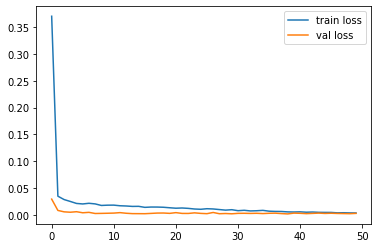

In [41]:
plt.plot(result['train_losses'], label = "train loss")
plt.plot(result['val_losses'], label = "val loss")
plt.legend()
plt.show()


(120,) (120,)


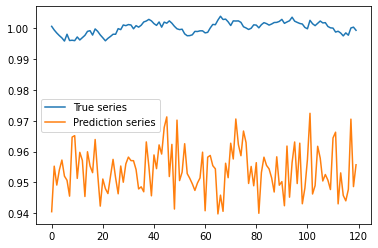

(120,) (120,)


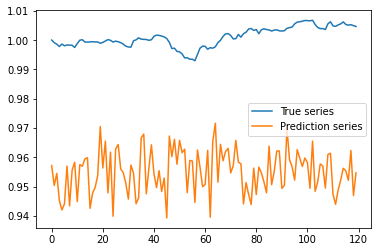

(120,) (120,)


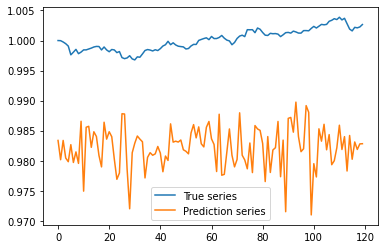

(120,) (120,)


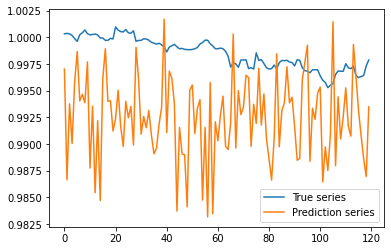

(120,) (120,)


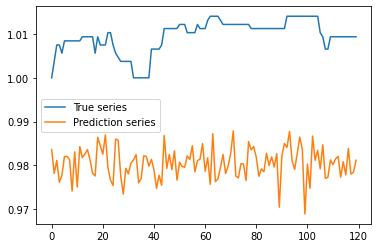

(120,) (120,)


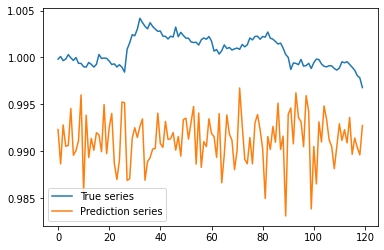

(120,) (120,)


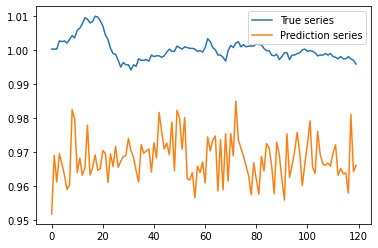

(120,) (120,)


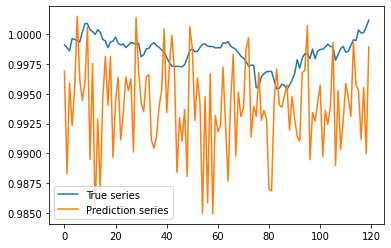

(120,) (120,)


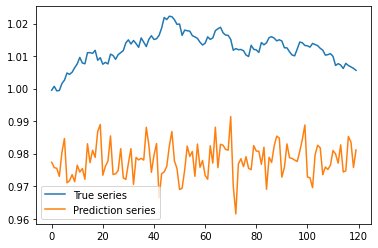

(120,) (120,)


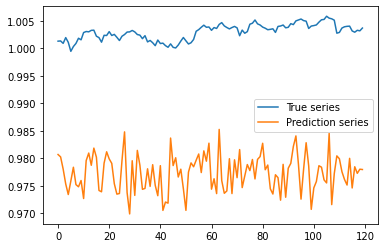

(120,) (120,)


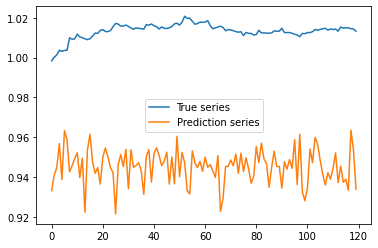

Namespace(L2_rate=0.0001, batch_size=32, device='cuda', dropout=0.2, hidden_dim=200, input_dim=9, learning_rate=0.0001, n_layers=1, num_epoch=50, output_dim=1, use_bn=True, x_frames=360, y_frames=120) 
SES 사용
mean absolute error * 10E5 is 13618.628680706024


In [42]:
testloader = DataLoader(partition['train'], batch_size = 1, shuffle = True, drop_last = True)
model.eval()
# evaluate

with torch.no_grad():
    for i, (X, y) in enumerate(testloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)
        model.hidden = model.init_hidden(X.shape[1])

        # en-decoder outputs tensor 
        y_pred = model(X)
        
        # y values to cpu
        y_true = y_true.cpu().detach().numpy().reshape(-1)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1)

        print(y_true.shape, y_pred.shape)

        plt.plot(y_true, label = 'True series')
        plt.plot(y_pred, '-', label = 'Prediction series')
        plt.legend()
        plt.show()

        loss = mean_absolute_error(y_true, y_pred)
        mae =+ loss
        if i == 10:
            print(args, "\nSES 사용")
            print(f'mean absolute error * 10E5 is {(mae/5) * 10E5}')            
            break
